## Unprobed SeqFISH gene analysis

This notebook demonstrates imputation of unprobed genes for seqFISH ST dataset.

Input data can be downloaded from [seqfish.tar.gz](https://zenodo.org/record/8214466/files/seqfish.tar.gz?download=1), please extract it with
```sh
tar -xzvf seqfish.tar.gz
```
and change the variable `pre_datapath` in the next cell accordingly.

In [ ]:
import torch
import warnings
import pickle

import squidpy as sq
import numpy as np
import scanpy as sc
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns
from transpa.util import expTransImp


warnings.filterwarnings('ignore')
pre_datapath = "../../output/preprocessed_dataset/seqFISH_single_cell.pkl"

seed = 10
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

#### Step 1. Load preprocessed SeqFISH and single-cell reference datasets. 
Retrieve leiden clusters if uncertainty estimation is required

In [2]:

with open(pre_datapath, 'rb') as infile:
    spa_adata, scrna_adata, raw_spatial_df, raw_scrna_df, raw_shared_gene = pickle.load(infile)
    cls_key = 'leiden'
    classes = scrna_adata.obs[cls_key]
    ct_list = np.unique(classes)

### Step 2. Select genes from single cell reference data
#### 2.1 Select top-1000 highly variable genes

In [3]:
sc.pp.highly_variable_genes(scrna_adata, n_top_genes=1000)
scrna_adata

AnnData object with n_obs × n_vars = 32844 × 29452
    obs: 'cell', 'barcode', 'sample', 'pool', 'stage', 'sequencing.batch', 'theiler', 'doub.density', 'doublet', 'cluster', 'cluster.sub', 'cluster.stage', 'cluster.theiler', 'stripped', 'celltype', 'colour', 'sizeFactor', 'leiden'
    var: 'ENSEMBL', 'SYMBOL', 'SymbolUniq', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

#### 2.2 Uniformly select 1000 more genes
Uniformly select 1000 more genes from single-cell reference, take union between highly-variable and random genes, and exclude probed 351 genes to retain the final unprobed genes

In [4]:
test_genes = np.setdiff1d(scrna_adata.var_names[scrna_adata.var['highly_variable']], raw_shared_gene)
n_valid_hc_sc_genes = len(test_genes)
print(len(test_genes), " valid hv sc genes")
np.random.seed(42)
test_genes = np.setdiff1d(np.union1d(test_genes, np.random.choice(scrna_adata.var_names, 1000, replace=False)), raw_shared_gene)
len(test_genes)

802  valid hv sc genes


1754

### Step 3. Run TransImpLR with uncertainty score estimation

Run low-rank mode, raw cell as gene profile, and turn on uncertainty estimation with 200 local bootstrap samples.

In [5]:
res = expTransImp(
        df_ref=raw_scrna_df,
        df_tgt=raw_spatial_df,
        train_gene=raw_shared_gene,
        test_gene=np.concatenate([raw_shared_gene, test_genes]),
        n_simulation=200,
        signature_mode='cell',
        mapping_mode='lowrank',
        classes=classes,
        n_epochs=2000,
        seed=seed,
        device=device)

[TransImp] Epoch: 2000/2000, loss: 0.781033, (IMP) 0.781033: 100%|██████████| 2000/2000 [00:32<00:00, 61.25it/s]


### Step 4. Prepare adata object for imputation

In [6]:
imp_adata = sc.AnnData(res[0])
imp_adata.var_names = np.concatenate([raw_shared_gene, test_genes])
imp_adata.obs = spa_adata.obs.copy()
imp_adata.obsm = spa_adata.obsm
imp_adata.obsp = spa_adata.obsp

### Step 5. Compute spatial autocorrelation with Squidpy

In [7]:
sq.gr.spatial_autocorr(
    imp_adata,
    n_jobs=10,
)

### Step 6. Rank unprobed genes by uncertainty scores (sigmoid transformed)

In [8]:
df_var = pd.DataFrame(res[1], index=np.concatenate([raw_shared_gene, test_genes]), columns=['pred_var'])
df_var.loc[test_genes].sort_values(axis=0, by='pred_var', ascending=True)

pred_var
Rplp0    0.498482
Rpl13    0.498531
Rps27a   0.498591
Rps6     0.498615
Rps14    0.498619
...           ...
Gm15290  0.500156
Gm14344  0.500156
Gm14243  0.500156
Gm14174  0.500156
Gm29129  0.500156

[1754 rows x 1 columns]

### Step 7. Merge unprobed and observed probed genes and test cell type markers

Figures below show a lot of unrpbed genes (name with postfix "_imp") are higher ranked markers

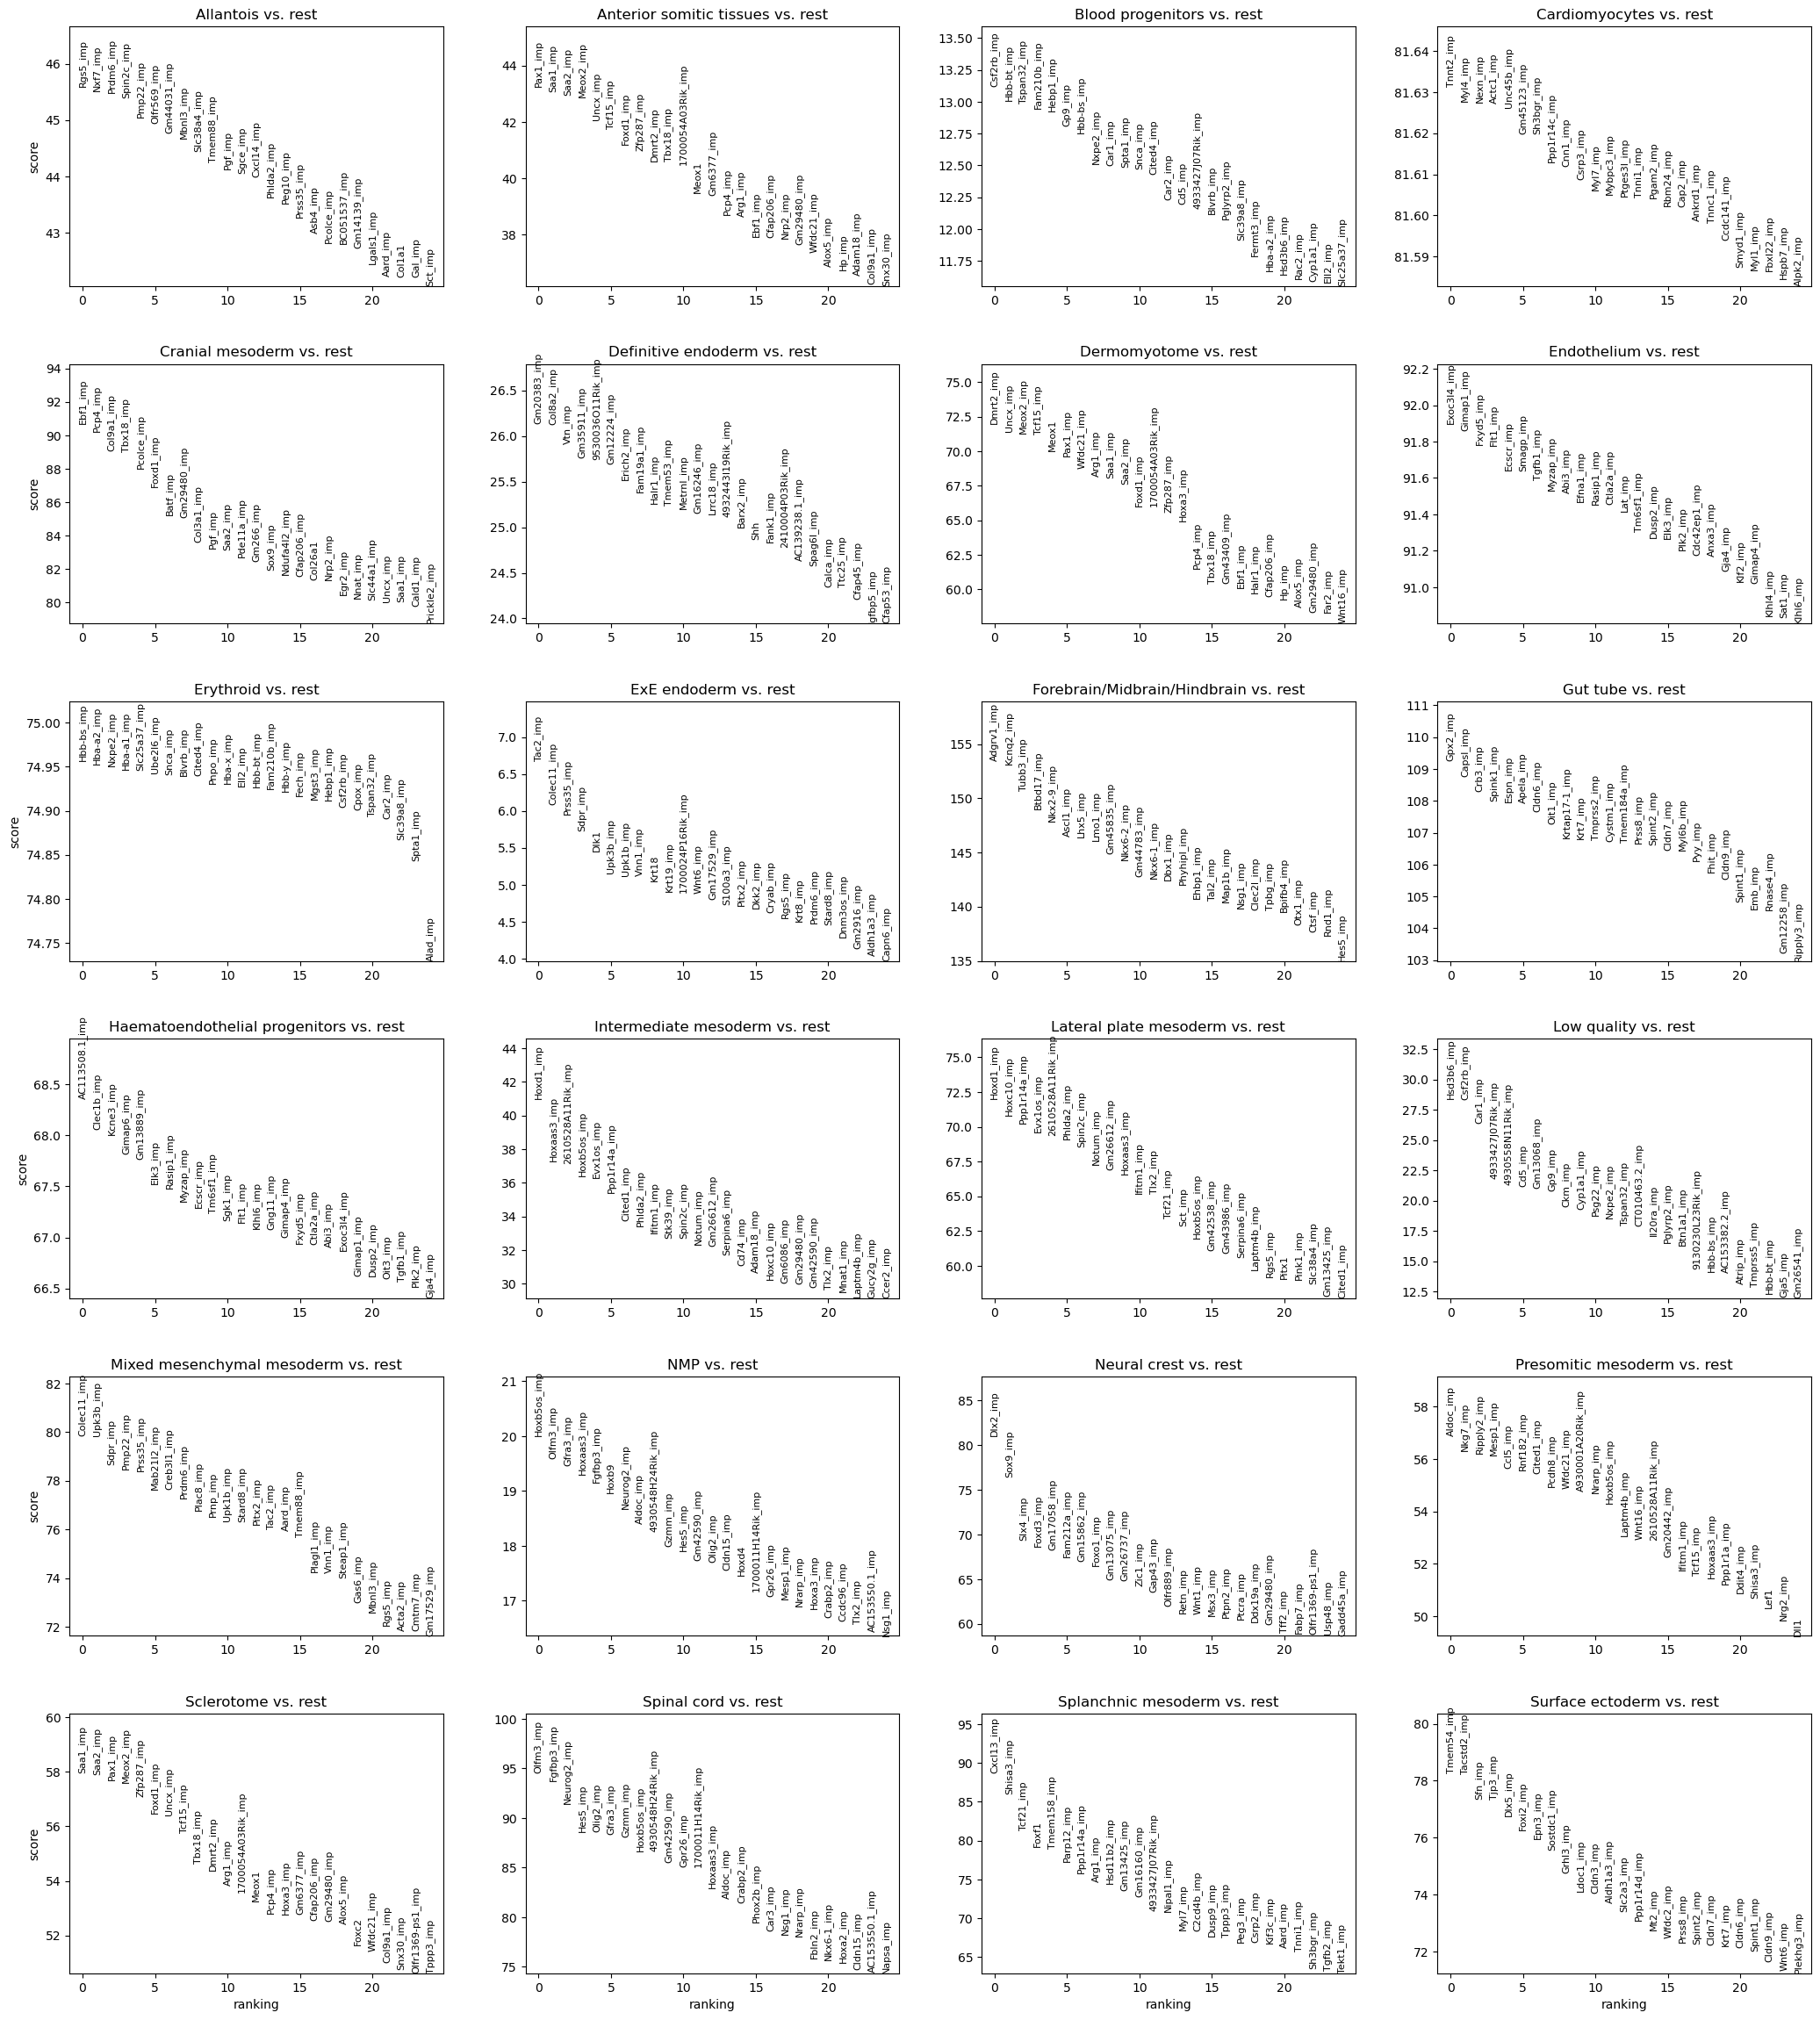

In [9]:
merged_adata = sc.AnnData(np.hstack([res[0][:, len(raw_shared_gene):], spa_adata.X.toarray()]))
merged_adata.var_names = np.concatenate([[f'{g}_imp' for g in test_genes], spa_adata.var_names])
merged_adata.obs = spa_adata.obs.copy()
merged_adata.obsm = spa_adata.obsm
merged_adata.obsp = spa_adata.obsp
sq.gr.spatial_autocorr(
    merged_adata,
    n_jobs=10,
)
sc.tl.rank_genes_groups(merged_adata, 'celltype_mapped_refined', method='wilcoxon')
sc.pl.rank_genes_groups(merged_adata, n_genes=25, sharey=False)

In [10]:
ratio_imp = []
for jth_ct in range(len(merged_adata.uns['rank_genes_groups']['names'][0])):
    imp_counter = 0
    for ith in range(25):
        # print(merged_adata.uns['rank_genes_groups']['names'][ith][jth_ct])
        # raise
        if merged_adata.uns['rank_genes_groups']['names'][ith][jth_ct].endswith("_imp"):
            imp_counter += 1
    ratio_imp.append(imp_counter / 25)

### Step 8. Plot ratios of unprobed markers in each cell type

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23]),
 [Text(0, 0, 'Allantois'),
  Text(1, 0, 'Anterior somitic tissues'),
  Text(2, 0, 'Blood progenitors'),
  Text(3, 0, 'Cardiomyocytes'),
  Text(4, 0, 'Cranial mesoderm'),
  Text(5, 0, 'Definitive endoderm'),
  Text(6, 0, 'Dermomyotome'),
  Text(7, 0, 'Endothelium'),
  Text(8, 0, 'Erythroid'),
  Text(9, 0, 'ExE endoderm'),
  Text(10, 0, 'Forebrain/Midbrain/Hindbrain'),
  Text(11, 0, 'Gut tube'),
  Text(12, 0, 'Haematoendothelial progenitors'),
  Text(13, 0, 'Intermediate mesoderm'),
  Text(14, 0, 'Lateral plate mesoderm'),
  Text(15, 0, 'Low quality'),
  Text(16, 0, 'Mixed mesenchymal mesoderm'),
  Text(17, 0, 'NMP'),
  Text(18, 0, 'Neural crest'),
  Text(19, 0, 'Presomitic mesoderm'),
  Text(20, 0, 'Sclerotome'),
  Text(21, 0, 'Spinal cord'),
  Text(22, 0, 'Splanchnic mesoderm'),
  Text(23, 0, 'Surface ectoderm')])

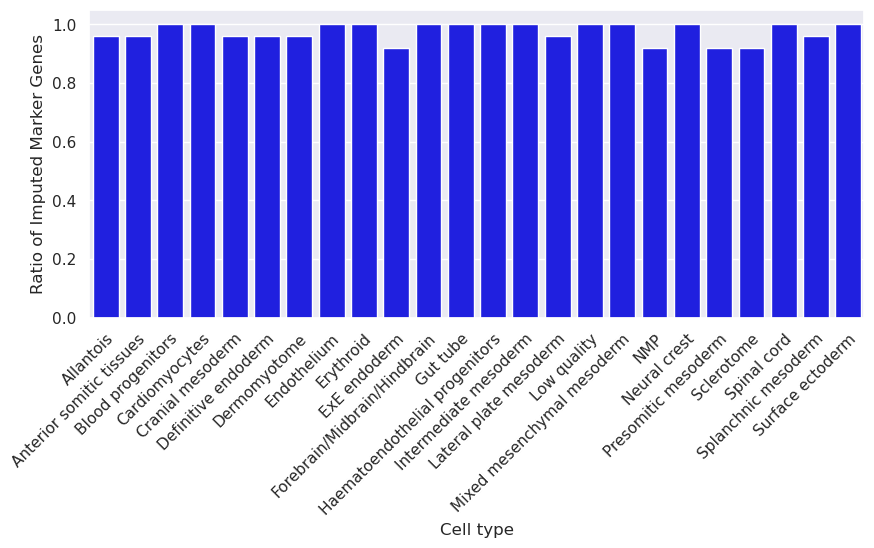

In [11]:
sns.set(rc={'figure.figsize':(10,4), 'figure.dpi':100})

sns.barplot(x=pd.Series(np.unique(merged_adata.obs.celltype_mapped_refined), name='Cell type'), color='blue', y=pd.Series(ratio_imp, name="Ratio of Imputed Marker Genes"))
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')

In [12]:
def plot(genes, spa_adata, n_cols=5, figsize=(20, 20), dpi=100):
    genes = list(set(list(genes)))
    sns.set(rc={'figure.figsize':figsize, 'figure.dpi': dpi})
    plt.rcParams.update({"font.size":30, 'axes.titlesize':30})
    pre_exprs = [spa_adata[:, gene].X.toarray().flatten() for gene in set(list(genes))]
    exprs = []
    for expr in pre_exprs:
        qt = np.quantile(expr, 0.1)
        expr[expr < qt] = qt
        # qt = np.quantile(expr, 0.85)
        # expr[expr > qt] = qt
        exprs.append(expr)
    titles = [f"{gene}\n M.I. {spa_adata.uns['moranI'].loc[gene].I:.3f}" for gene in genes]
    # sc.pl.spatial(spa_adata, color=[gene], spot_size=0.1, title='Truth')
    
    
    tmp_adata = sc.AnnData(np.array(exprs).T)
    print(tmp_adata)
    tmp_adata.var_names = titles
    tmp_adata.obsm['spatial'] = spa_adata.obsm['spatial'].copy()
    sc.pl.spatial(tmp_adata, color=titles, spot_size=0.1, title=titles, color_map='OrRd', legend_fontsize=10, wspace=0.00001, hspace=0.5, ncols=n_cols)
    

### Step 10. Plot the top-1 markers in each cell type

Postfix "_imp" indicates unprobed genes

AnnData object with n_obs × n_vars = 57536 × 23


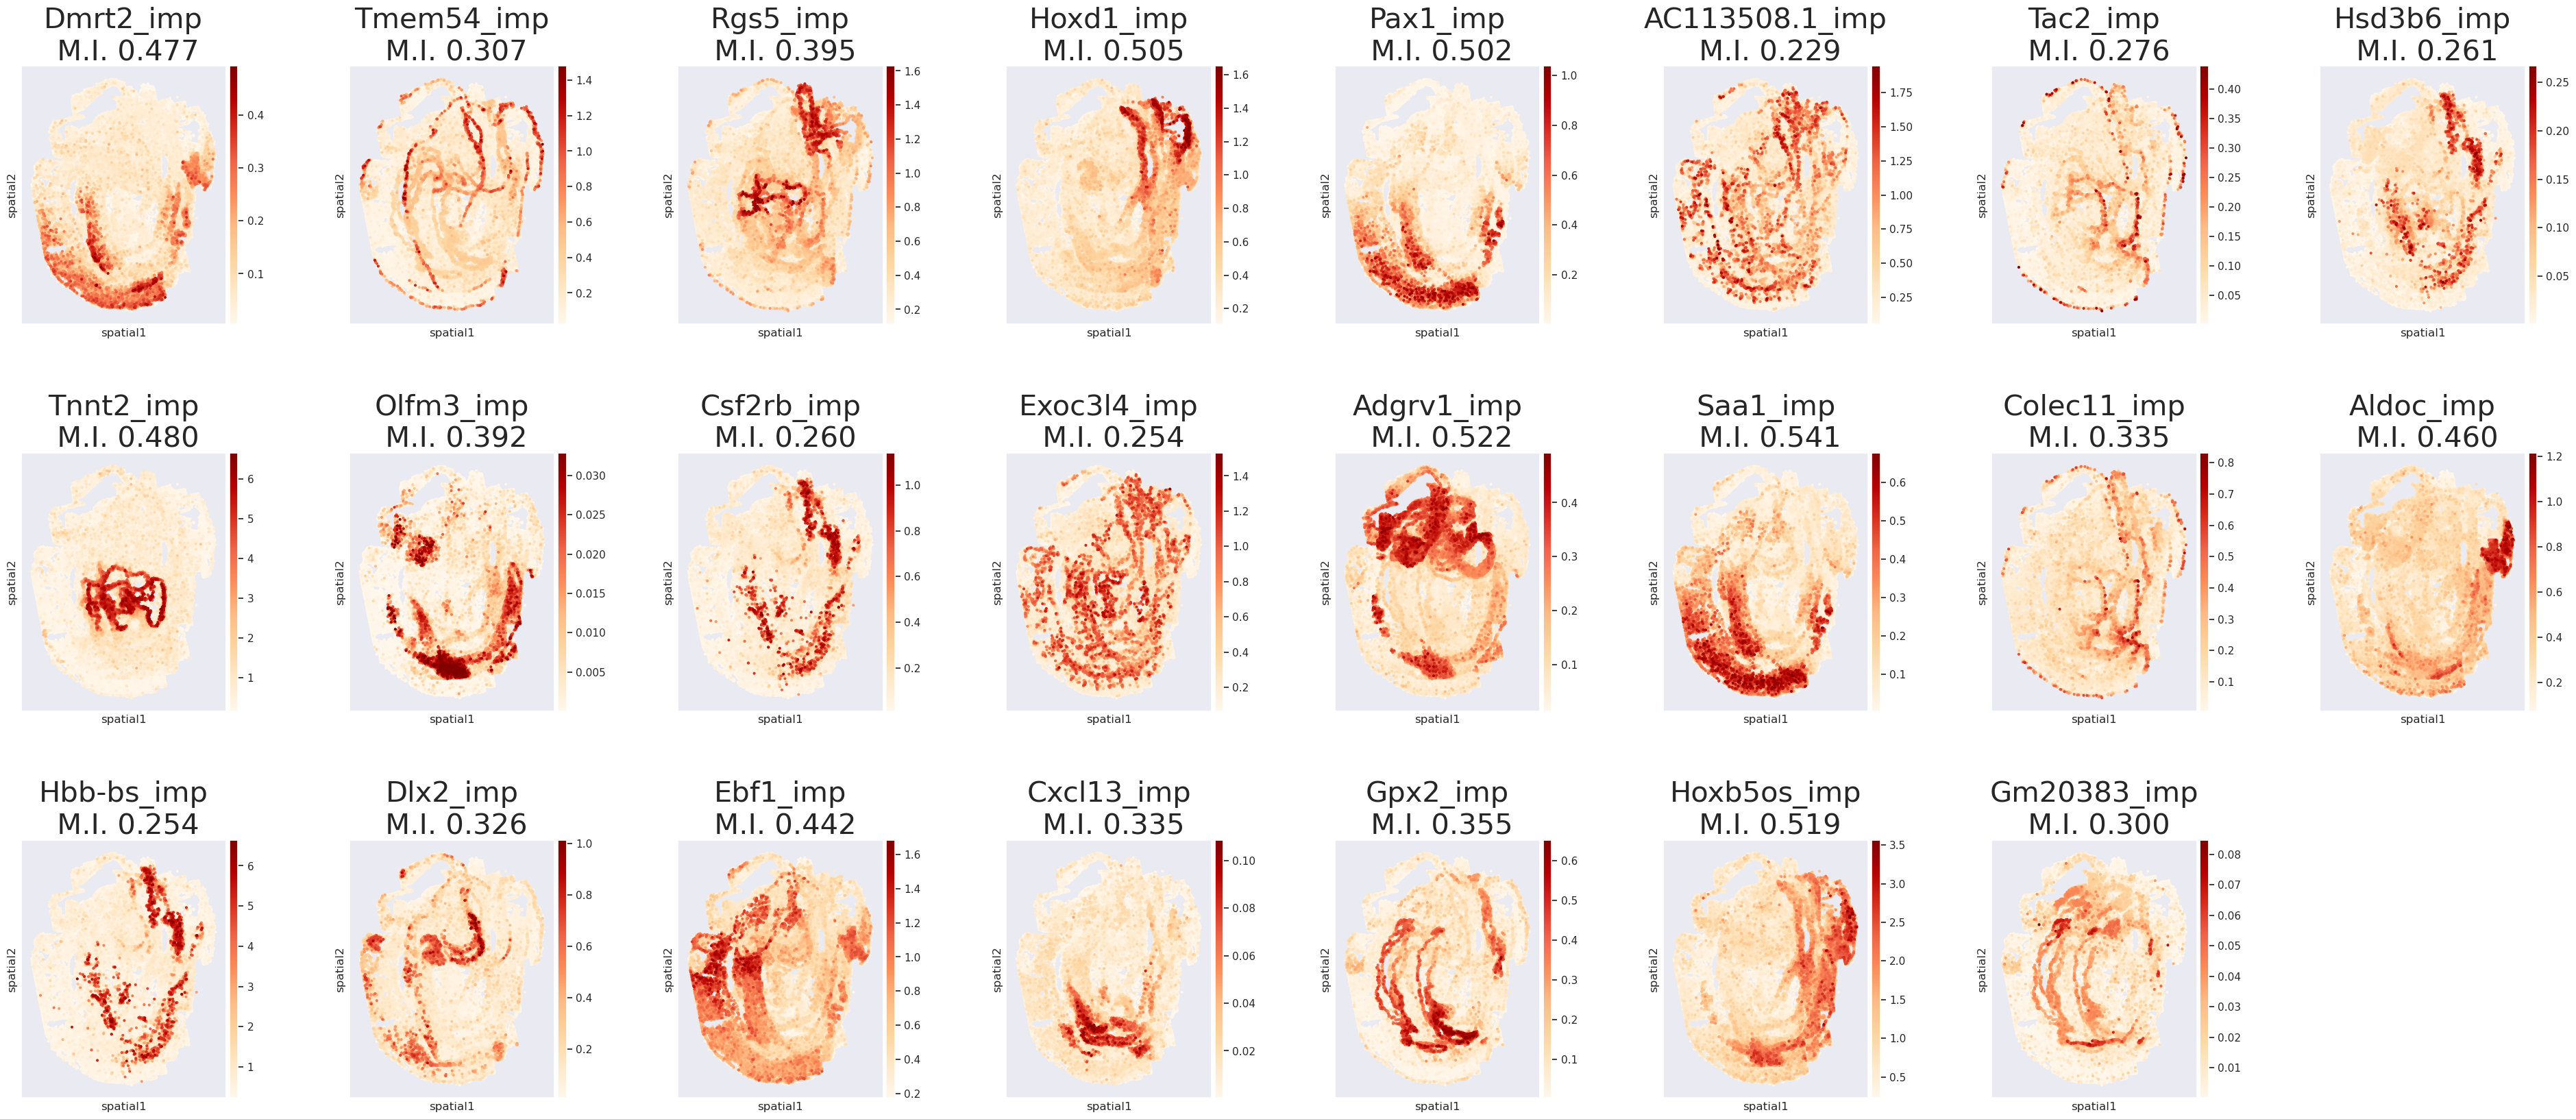

In [13]:
plot(list(merged_adata.uns['rank_genes_groups']['names'][0]), merged_adata, n_cols=8, figsize=(6,6), dpi=100)